In [ ]:
# import libraries...

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

In [ ]:
#load datasets...

data = pd.read_csv("/content/diabetes.csv")
columns = ['Glucose', 'BloodPressure', 'SkinThickness','Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
data[columns] = data[columns].replace(0, np.NaN)
data = data.dropna()

#------------------------------------------------------------------------------     #Data dividing for tran, valid and test
ntrain = int(len(data)*0.85)
nvalid = int(len(data)*0.95)
#------------------------------------------------------------------------------     # train, validation and test data
Xtrain = data.iloc[:ntrain, 0:8].values
Xvalid = data.iloc[ntrain:nvalid, 0:8].values
Xtest = data.iloc[nvalid:, 0:8].values

Ytrain = data.iloc[:ntrain, 8:9].values
Yvalid = data.iloc[ntrain:nvalid, 8:9].values
Ytest = data.iloc[nvalid:, 8:9].values
#-------------------------------------------------------------------------------      # standardized data
scaler_xtrain = MinMaxScaler()
xtrain_sc = scaler_xtrain.fit_transform(Xtrain)

scaler_xvalid = MinMaxScaler()
xvalid_sc = scaler_xvalid.fit_transform(Xvalid)

scaler_xtest = MinMaxScaler()
xtest_sc = scaler_xtest.fit_transform(Xtest)
#------------------------------------------------------------------------------       # Adding ones column in the data
ones_tn = np.ones(shape = (xtrain_sc.shape[0],1))
xtrain_sc = np.hstack([ones_tn, xtrain_sc])

ones_va = np.ones(shape = (xvalid_sc.shape[0],1))
xvalid_sc =  np.hstack([ones_va, xvalid_sc])

ones_ts = np.ones(shape = (xtest_sc.shape[0],1))
xtest_sc = np.hstack([ones_ts, xtest_sc])

train = np.append(Ytrain, xtrain_sc, axis = 1)

In [ ]:
def intializer(layers):
  np.random.seed(3)
  W = np.random.randn(layers[0], layers[1])
  return (W)

def sigmoid(z):
  sig = 1.0/(1.0+np.exp(-z))
  return (sig)

def decision_fn(A):                                                            
  dec = np.where(A > 0.5, 1, 0)
  return(dec)

def predict(X, W):
  Z = np.dot(X, W)
  A = sigmoid(Z)
  A = decision_fn(A)
  return (A)

In [ ]:
def minimumcost(vault):
  ix = vault[4].index(min(vault[4]))                         
  W = vault[0][ix]
  W = W.T
  return (W)


def SPLPrediction(X,Y,W):
  pred = predict(X, W)
  accuracy = accuracy_score(Y, pred)*100
  f1 = f1_score(Y, pred)*100
  misclassification = 100-accuracy
  result = [accuracy, f1, misclassification]
  return (result)


In [ ]:
def indicesShuffle(number):
  indexlist = []
  i = 0
  while (i< number):
    n = np.random.randint(0, number)
    if n in indexlist:
      i = i
    else:
      indexlist.append(n)
      i = i + 1
  return (indexlist)

def shuffler(X):
  number = X.shape[0]
  indexShuffle = indicesShuffle(number)
  shuffleArray = np.empty((X.shape))
  for stack,ix in zip(indexShuffle, range(number)):
    shuffleArray[ix] = X[stack]
  return (shuffleArray, indexShuffle)


In [ ]:
def SPLGDCV(X, Y, lrT,layersT, shuffleTime, simulationT,lrV, labdV, layersV, XV, YV, simulationV):   #algorithm
  costs = []
  weights = []
  zpred = []
  Apred = []
  errpred = []
  grads = []
  results = []
  shuffdict = {}
  W = intializer(layersT)
  shuffle = 1
  while (shuffle < shuffleTime):
    xtrain, indexes = shuffler(train)
    shuffdict['shuffle '+str(shuffle)] = xtrain
    xdata = xtrain[:, 1:10]
    ydata = xtrain[:, 0:1]
    for epoch in range(simulationT):
      Z = np.dot(xdata, W)  
      A = sigmoid(Z)  
      error = A - ydata
      m = A.shape[0]
      loss = -(np.dot(ydata.T, np.log(A)) + np.dot((1-ydata.T),np.log(1-A)))
      cost = (np.sum(loss)/m) 
      grad =np.dot(xdata.T, error)
      costs.append(cost)
      weights.append(W.T)
      zpred.append(Z.T)
      Apred.append(A.T)
      errpred.append(error.T)
      grads.append(grad.T)
      W = W - (lrT/m)*(grad)
    Tvault = [weights, zpred, Apred, errpred, costs]
    TWmin = minimumcost(Tvault)
    validvault = validator(XV, YV, TWmin, lrV, simulationV, layersV, labdV)
    Vwmin = minimumcost(validvault)
    result = SPLPrediction(xtest_sc, Ytest, Vwmin)
    results.append(result)
    shuffle = shuffle + 1
  vault = [weights, zpred, Apred, errpred, costs, grads] 
  return (results)




def validator(X, Y, W, lr,epochs,layers,labd):                                     # L2- Regualrised gradient descent for validation data
  costs = []
  weights = []
  Zpred = []
  Apred = []
  errpred = []
  grads = []
  for epoch in range(epochs):
    Z = np.dot(X, W)
    A = sigmoid(Z)
    error = A - Y
    m = A.shape[0]
    loss = -(np.dot(Y.T, np.log(A)) + np.dot((1-Y.T),np.log(1-A)))
    cost = (np.sum(loss)/m) + (labd/(2*m)*np.dot(W.T, W))
    grad =np.dot(X.T, error)
    weights.append(W.T)
    costs.append(cost)
    Zpred.append(Z.T)
    Apred.append(A.T)
    errpred.append(error.T)
    grads.append(grad.T)
    W = W - (lr/m)*(grad)-(lr*labd*W)
  vault =[weights, Zpred, Apred, errpred, costs, grads]
  return (vault)

use 85-95-5 data split for all tests

TEST-1

In [ ]:
# use 85-95-5 data split

lrT = 0.4
layersT = [xtrain_sc.shape[1], 1]
shuffleTime = 10
simulationT = 5000


lrV = 0.01
labdV = 0.001
layersV = [xvalid_sc.shape[1], 1]
simulationV = 1500
results1 = SPLGDCV(xtrain_sc, Ytrain, lrT, layersT,shuffleTime, simulationT,lrV, labdV, layersV, xvalid_sc, Yvalid, simulationV)

avg_results1 = np.asarray(results1)
accuracy1 = np.mean(avg_results1[:, 0:1])
f1_1 = np.mean(avg_results1[:, 1:2])
misclf1 = np.mean(avg_results1[:, 2:3])

In [ ]:
accuracy1, f1_1, misclf1

(85.0, 72.72727272727272, 15.0)

TEST-2

In [ ]:
lrT = 0.4
layersT = [xtrain_sc.shape[1], 1]
shuffleTime = 10
simulationT = 5000


lrV = 0.1
labdV = 0.01
layersV = [xvalid_sc.shape[1], 1]
simulationV = 2000
results2 = SPLGDCV(xtrain_sc, Ytrain, lrT, layersT,shuffleTime, simulationT,lrV, labdV, layersV, xvalid_sc, Yvalid, simulationV)

avg_results2 = np.asarray(results2)
accuracy2 = np.mean(avg_results2[:, 0:1])
f1_2 = np.mean(avg_results2[:, 1:2])
misclf2 = np.mean(avg_results2[:, 2:3])

In [ ]:
accuracy2, f1_2, misclf2

(85.0, 72.72727272727272, 15.0)

TEST-3

In [ ]:
lrT = 0.8
layersT = [xtrain_sc.shape[1], 1]
shuffleTime = 50
simulationT = 5000


lrV = 0.05
labdV = 0.002
layersV = [xvalid_sc.shape[1], 1]
simulationV = 1000
results3 = SPLGDCV(xtrain_sc, Ytrain, lrT, layersT,shuffleTime, simulationT,lrV, labdV, layersV, xvalid_sc, Yvalid, simulationV)

avg_results3 = np.asarray(results3)
accuracy3 = np.mean(avg_results3[:, 0:1])
f1_3 = np.mean(avg_results3[:, 1:2])
misclf3 = np.mean(avg_results3[:, 2:3])

In [ ]:
accuracy3, f1_3, misclf3

(85.0, 72.72727272727272, 15.0)

Accuracy of TEST-1 =  85.0
Accuracy of TEST-2 =  85.0
Accuracy of TEST-3 =  85.0


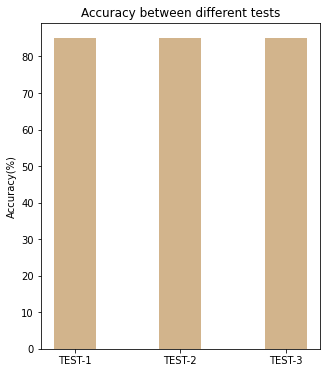

In [ ]:
print("Accuracy of TEST-1 = ",accuracy1)
print("Accuracy of TEST-2 = ", accuracy2)
print("Accuracy of TEST-3 = ", accuracy3)

plt.figure(figsize = (5,6))
plt.bar(x = ['TEST-1', 'TEST-2', 'TEST-3'], height = [accuracy1, accuracy2, accuracy3], width = 0.4, color = 'tan')
plt.title("Accuracy between different tests")
plt.ylabel("Accuracy(%)")
plt.show()

